# Task1: Sentiment Classification
### 1.Feature Engineering
#### (1)Load Dataset

In [ ]:
import pandas as pd
import numpy as np 

import os
import bz2
import re 

train= bz2.BZ2File('data/train.ft.txt.bz2').readlines()
test= bz2.BZ2File('data/test.ft.txt.bz2').readlines()


#### (2)Assign the number of reviews

In [ ]:
#set the size of the data you want to train
#training
num_train = 1000000

#testing
num_test = 100000

train = [x.decode('utf-8') for x in train[:num_train]]
test = [x.decode('utf-8') for x in test[:num_test]]

(3) separate features and labels

In [ ]:
train_labels = []
train_sentences = []
for x in train:
    if x.split(' ')[0] == '__label__1':
        train_labels.append(0)
    else:
        train_labels.append(1)
    train_sentences.append(x.split(' ', 1)[1][:-1].lower())


#do the same with testing set
test_labels = []
test_sentences = []
for x in test:
    if x.split(' ')[0] == '__label__1':
        test_labels.append(0)
    else:
        test_labels.append(1)
    test_sentences.append(x.split(' ', 1)[1][:-1].lower())


(4) Transform to DataFrame

In [ ]:
train = pd.DataFrame({'text':train_sentences,'label':train_labels})
test = pd.DataFrame({'text':test_sentences,'label':test_labels})
train.head(5)

,text,label
0,stuning even for the non-gamer: this sound tra...,1
1,the best soundtrack ever to anything.: i'm rea...,1
2,amazing!: this soundtrack is my favorite music...,1
3,excellent soundtrack: i truly like this soundt...,1
4,"remember, pull your jaw off the floor after he...",1


(4) Add review length as a new feature

In [ ]:
# Get the 'text' column from the 'train' dataset
text_column = train['text']

# Convert each element in the 'text' column to lowercase and split into a list of words
lowercase_text = text_column.str.lower()
word_lists = lowercase_text.str.split()

# Calculate the number of words in each text
word_counts = word_lists.apply(len)

# Add the calculated number of words column to the 'train' dataset
train['review_length'] = word_counts


train.head()

,text,label,review_length
0,stuning even for the non-gamer: this sound tra...,1,80
1,the best soundtrack ever to anything.: i'm rea...,1,97
2,amazing!: this soundtrack is my favorite music...,1,129
3,excellent soundtrack: i truly like this soundt...,1,118
4,"remember, pull your jaw off the floor after he...",1,87


In [ ]:
# Do the same with testing set

text_column = test['text']
lowercase_text = text_column.str.lower()
word_lists = lowercase_text.str.split()
word_counts = word_lists.apply(len)

test['review_length'] = word_counts


test.head()

,text,label,review_length
0,great cd: my lovely pat has one of the great v...,1,106
1,one of the best game music soundtracks - for a...,1,148
2,batteries died within a year ...: i bought thi...,0,60
3,"works fine, but maha energy is better: check o...",1,37
4,great for the non-audiophile: reviewed quite a...,1,69


### 2. Data Visualization

(1) Negative VS Positive

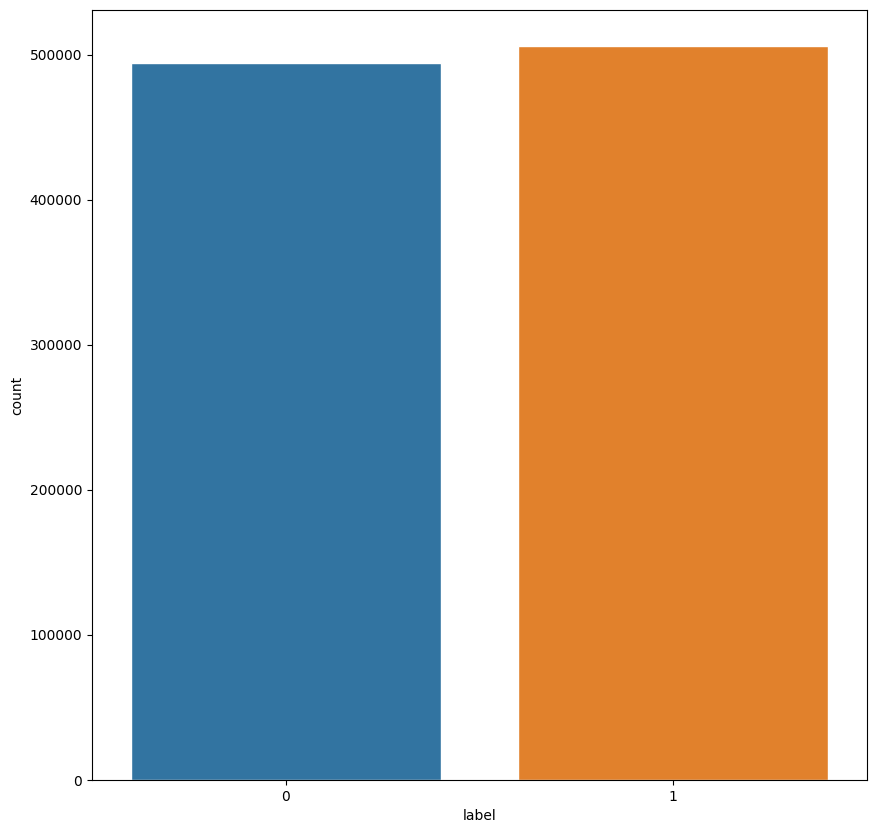

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define plot size and style
fig, ax = plt.subplots(figsize=(10, 10))
sns.set_style("darkgrid")

# Create the countplot
sns.countplot(ax=ax, x=train["label"])

# Show the plot
plt.show()


As we can see from the mean and standard deviation shown above, the number of positive and negative reviews is roughly equal, indicating that the data set is of well-defined and there is no obvious class imbalance.

### 3.Data Cleaning
#### (1) Remove HTML labels, punctuations etc. and set stopwords

In [ ]:
import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords


def remove_html(text):
  cleanr = re.compile('<.*?>')
  return cleanr.sub(r" ",text)

def remove_url(text):
     url=re.compile(r"https?://\S+|www\.\S+")
     return url.sub(r" ",text)

import string
def remove_punc(text):
   table=str.maketrans(' ',' ',string.punctuation)
   return text.translate(table)

def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

stop=set(stopwords.words("english"))
def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)


for i, row in train.iterrows():
    text = row['text']
    text = remove_url(text)
    text = remove_html(text)
    text = remove_punc(text)
    text = remove_num(text)
    text = remove_stopword(text)
    train.at[i, 'text'] = text


for i, row in test.iterrows():
    text = row['text']
    text = remove_url(text)
    text = remove_html(text)
    text = remove_punc(text)
    text = remove_num(text)
    text = remove_stopword(text)
    test.at[i, 'text'] = text




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### (2) Convert all words to base form or stem

In [ ]:
import nltk
nltk.download('punkt')

def Stemming(text):

   stem=[]
   from nltk.corpus import stopwords
   from nltk.stem import SnowballStemmer

   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')

   word_tokens = nltk.word_tokenize(text)

   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem


train['text']=train['text'].map(Stemming)
test['text']=test['text'].map(Stemming)




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### 4.Modelling
#### (1) Use Tokenizer to vectorize the words

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM,GRU
from keras.preprocessing import sequence
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score    
from tensorflow.python.keras import models, layers, optimizers   
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D
from keras.layers import Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping


max_length=100
vocab_size=12000
embedding_dim=64
trunc_type="post"
oov_tok="<OOV>"
padding_type="post"
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)

#Use the fit_on_texts method to tokenize the training text data and generate a vocabulary
tokenizer.fit_on_texts(train['text'])

#Get the generated vocabulary, which maps each word to a unique integer:
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train['text'])

#Add paddings so that all the input sequences have the same length
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test['text'])

testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#### (2) Embedding

In [ ]:
from keras.layers import Embedding
embedded=Embedding(vocab_size, embedding_dim, input_length=max_length)

#### (3) Modelling
###### Here we choose to use Bidirectional LSTM for modelling and training
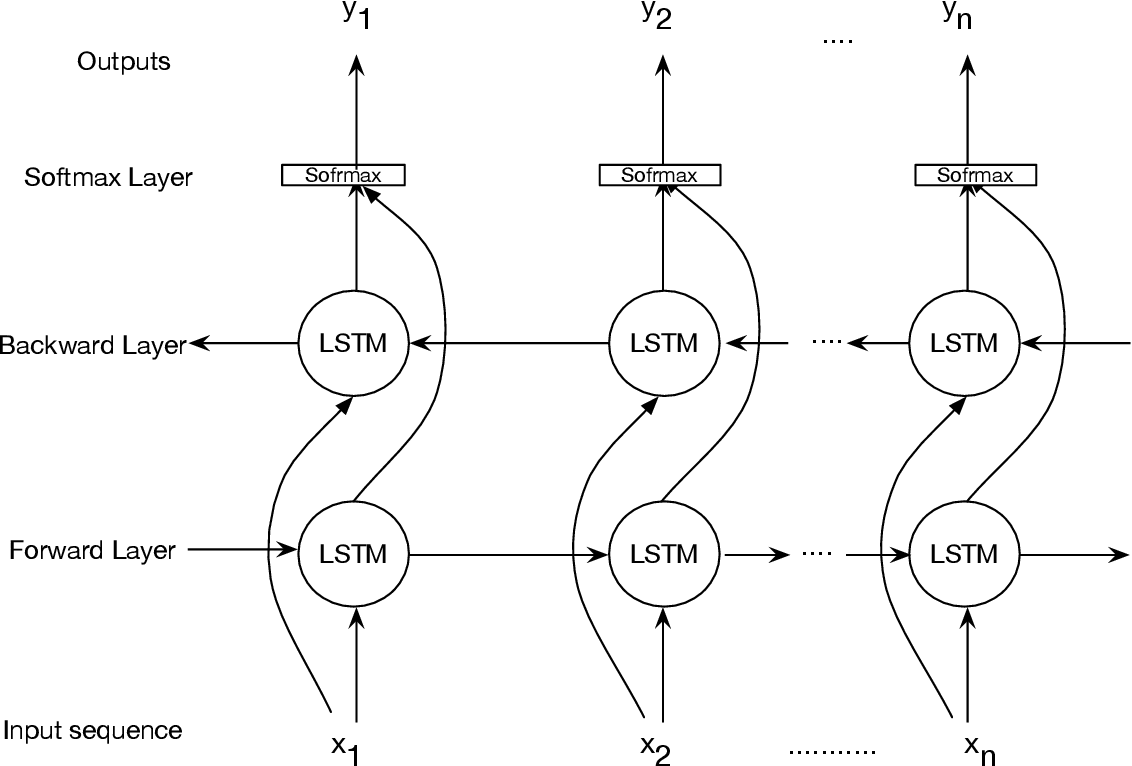

#### (4) Training

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(embedded)
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(256, 
            dropout=0.2)))

model.add(Dense(1))
model.add(Activation('sigmoid'))

adam=Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# train
history = model.fit(training_padded, train['label'], epochs=10, 
                    batch_size=256, verbose=1,
                    #set early stopping if needed: callbacks=[EarlyStopping(monitor='val_accuracy', patience=2)],
                    validation_data=(testing_padded, test['label']),
                    use_multiprocessing=True, #assign 8 processes to train simultaneously
                    workers=8)


Epoch 1/10
3907/3907 [==============================] - 277s 68ms/step - loss: 0.3143 - accuracy: 0.8632 - val_loss: 0.2607 - val_accuracy: 0.8928
Epoch 2/10
3907/3907 [==============================] - 196s 50ms/step - loss: 0.2561 - accuracy: 0.8943 - val_loss: 0.2598 - val_accuracy: 0.8940
Epoch 3/10
3907/3907 [==============================] - 191s 49ms/step - loss: 0.2464 - accuracy: 0.8988 - val_loss: 0.2470 - val_accuracy: 0.8982
Epoch 4/10
3907/3907 [==============================] - 186s 48ms/step - loss: 0.2374 - accuracy: 0.9031 - val_loss: 0.2405 - val_accuracy: 0.9017
Epoch 5/10
3907/3907 [==============================] - 190s 49ms/step - loss: 0.2293 - accuracy: 0.9067 - val_loss: 0.2351 - val_accuracy: 0.9041
Epoch 6/10
3907/3907 [==============================] - 190s 48ms/step - loss: 0.2220 - accuracy: 0.9101 - val_loss: 0.2301 - val_accuracy: 0.9063
Epoch 7/10
3907/3907 [==============================] - 186s 48ms/step - loss: 0.2159 - accuracy: 0.9130 - val_loss: 0

#### (5) Plotting the training process

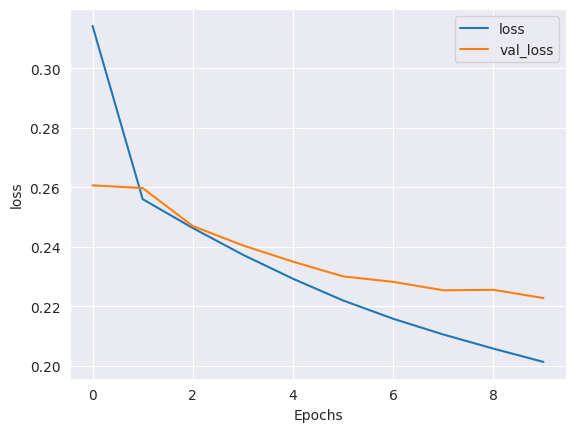

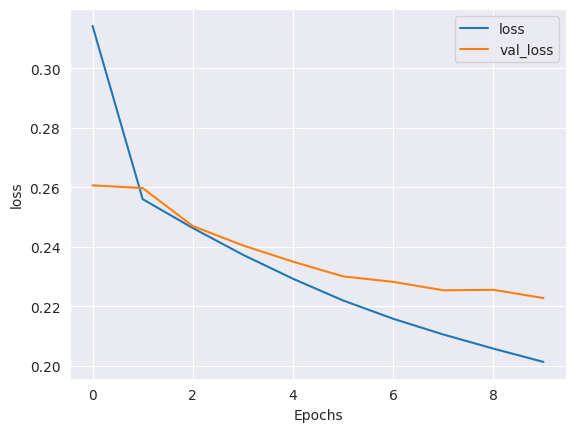

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "loss")

#### (6) Testing

In [ ]:
y_pred = model.predict(testing_padded)
y_pred = (y_pred > 0.5)
X_test=testing_padded
y_test=test['label']
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix

print('Accuracy: %f' % accuracy_score(y_test, y_pred))
print('Precision: %f' % precision_score(y_test, y_pred))
print('Recall: %f' % recall_score(y_test, y_pred))
print('F1 score: %f' % f1_score(y_test, y_pred))
print('ROC AUC: %f' % roc_auc_score(y_test, y_pred))


3125/3125 [==============================] - 22s 6ms/step
Accuracy: 0.909850
Precision: 0.910955
Recall: 0.910793
F1 score: 0.910874
ROC AUC: 0.909839


#### (7) Generalization ability test

In [ ]:
def Review(sentence):
   sequences = tokenizer.texts_to_sequences(sentence)
   padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

   prob=model.predict(padded)
   if prob>=0.8:
     print("Phenomenal")
   elif prob<0.8 and prob>=0.6:
     print("Good")
   elif prob<0.6 and prob>=0.4:
     print("Average") 
   elif prob<0.4 and prob>=0.2:
     print("Poor")   
   else:
       print("Terrible")

In [ ]:
sentence=['I recently purchased a watch and I am extremely unsatisfied with its quality and durability. The materials used are of the highest standard, making it very hard to wear and tear. Not only is it aesthetically unpleasing, but it also keeps inaccurate time and has many useless features. I have worn it daily for months now and it still looks and functions like new. I would definitely not recommend this watch to anyone who wants a high-quality, reliable timepiece.']
Review(sentence)

1/1 [==============================] - 1s 653ms/step
Terrible


# Task2: Review Summarization
### 1.Data Cleaning
#### (1) Load Dataset

In [1]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

data = pd.read_csv("data/Reviews.csv", error_bad_lines=False, engine="python")


In [2]:
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


#### (2) Drop useless values

In [3]:
data.drop_duplicates(subset=['Text'], inplace=True)
data.dropna(axis=0, inplace=True)

#### (3) Remove stopwords, HTML labels, punctuations etc. Then finish contraction mapping and stemming

In [4]:
collection = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                       "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                       "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would",

                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",

                       "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",

                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock",

                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as",

                       "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                       "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would", "they'd've": "they would have",

                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                       "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",

                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                       "you're": "you are", "you've": "you have"}


                    

import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def text_cleaner(text):
    
    #lowercase words
    cleaned = text.lower() 
        
    # remove HTML tags
    cleaned = BeautifulSoup(cleaned, "lxml").text 
    
    cleaned = re.sub(r'\([^)]*\)', '', cleaned)

    # remove quotes
    cleaned = re.sub('"', '', cleaned) 
    
    cleaned = ' '.join([collection[t] if t in collection else t for t in cleaned.split(" ")]) 
    cleaned = re.sub(r"'s\b", "", cleaned)
    cleaned = re.sub("[^a-zA-Z]", " ", cleaned) 
    tokens = [w for w in cleaned.split() if not w in stop_words]


    return " ".join([i for i in tokens if len(i) >= 3]).strip()



cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def summary_cleaner(text):
    '''
    clean summary column in dataset
    '''
    newString = re.sub('"', '', str(text))  # remove quotes
    newString = ' '.join([collection[t] if t in collection else t for t in newString.split(" ")])  # the dictionary that we will use for expanding the contractions
    newString = re.sub(r"'s\b", "", newString)
    # match all strings that contain a non-letter
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()  # lowercase words
    tokens = newString.split()
    newString = ''
    for i in tokens:
        if len(i) > 1:
            newString = newString+i+' '
    return newString


cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

#### (4) Add cleaned reviews and corresponding cleaned summaries to the DataFrame as two new features

In [6]:
data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
data['cleaned_summary'] = ['sostok ' + x + ' eostok' for x in data['cleaned_summary']]


### 2. Modeling and training
#### (1) Vectorize the words

In [7]:
max_len_text = 200
max_len_summary = 15
from sklearn.model_selection import train_test_split

#split dataset
x_tr, x_val, y_tr, y_val = train_test_split(data['cleaned_text'], data['cleaned_summary'], 
                        test_size=0.1, random_state=0, shuffle=True)

x_tokenizer = Tokenizer()

x_tokenizer.fit_on_texts(list(x_tr))

# vectorize the cleaned reviews
x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_val = x_tokenizer.texts_to_sequences(x_val)

# Add paddings so that all the input sequences have the same length
x_tr = pad_sequences(x_tr,  maxlen=max_len_text, padding='post')
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) + 1

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

# vectorize the cleaned summaries
y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_val = y_tokenizer.texts_to_sequences(y_val)

# padding zero upto maximum length
y_tr = pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) + 1

#### **(2) Embedding + Modeling**
This code segment defines a Seq2Seq Encoder-Decoder model for review summarization, which aims to encode a long input text sequence into a high-dimensional hidden state vector and decode it into a corresponding short text sequence. The encoder part of the model utilizes three LSTM layers to encode the input, while the decoder part uses one LSTM layer to generate the output sequence, with the output of the encoder as the initial state. Finally, a fully connected dense layer is used to map the hidden state vector to the probability distribution of words, in order to generate the summary sequence.  
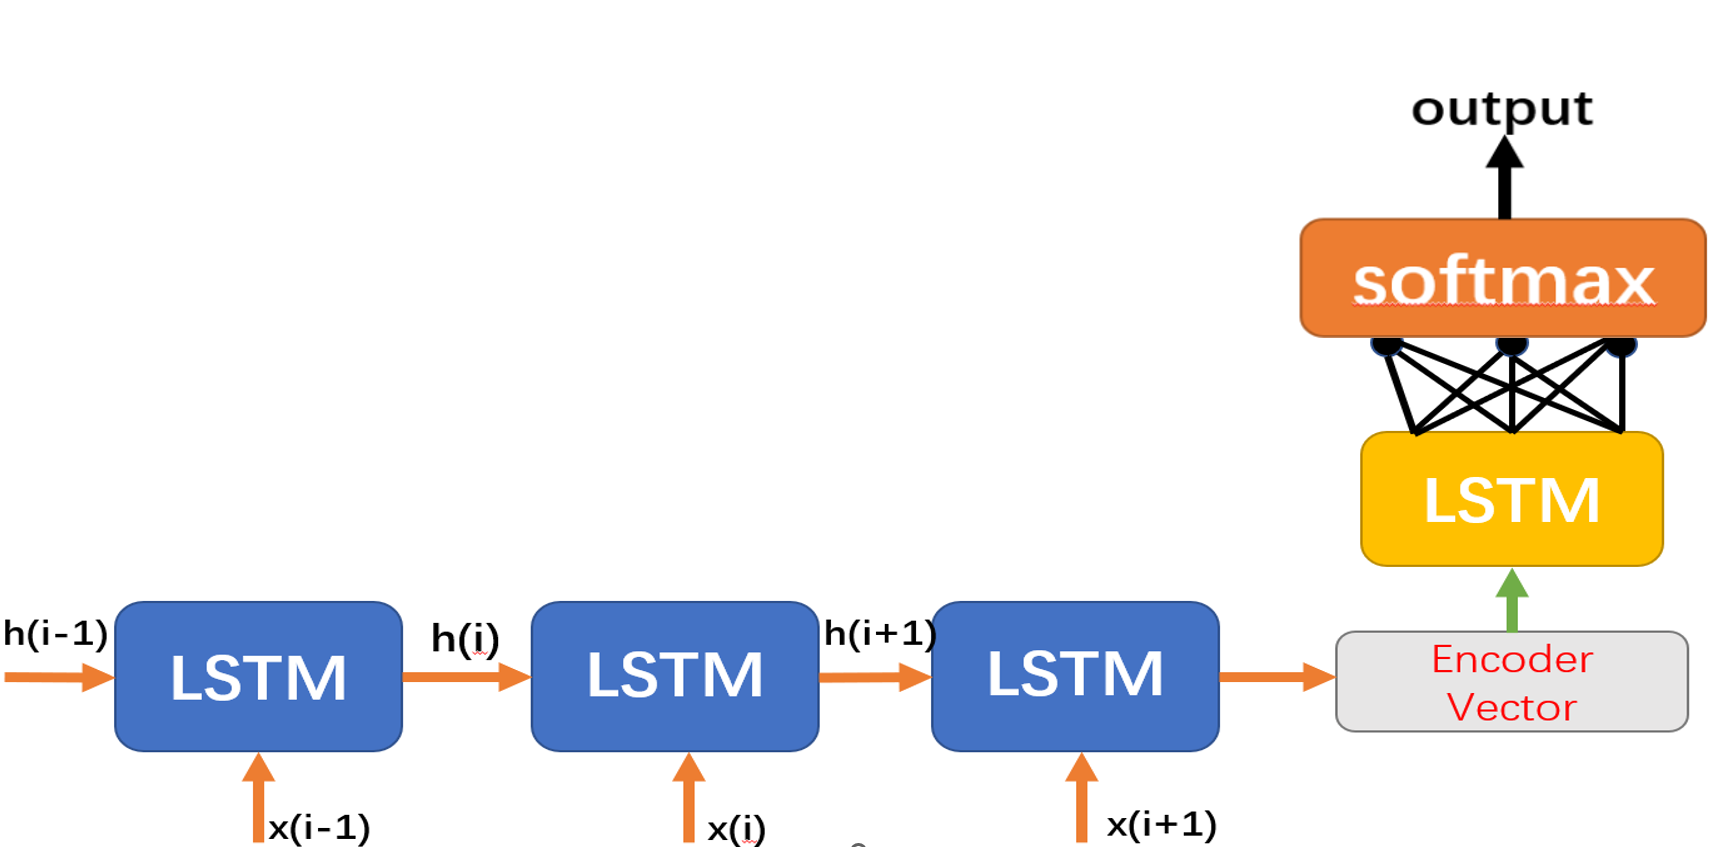

In [8]:
from keras import backend as K
K.clear_session()
latent_dim = 500

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [9]:
from keras import callbacks

# Define the CUDA device
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    print('GPU device not found. Using CPU instead.')
    device_name = '/cpu:0'
else:
    print(f'GPU device found: {device_name}')

with tf.device(device_name):
  from tensorflow.keras.optimizers import Adam
  adam=Adam(learning_rate=0.001)
  model.compile(optimizer=adam, loss='sparse_categorical_crossentropy')

with tf.device(device_name):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit([x_tr, y_tr[:, :-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:], 
                        epochs=5, batch_size=512,
                        #callbacks=es,
                        validation_data=([x_val, y_val[:, :-1]], 
                        y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))



Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU device found: /device:GPU:0
Epoch 1/5
692/692 [==============================] - 1185s 2s/step - loss: 2.1723 - val_loss: 1.8383
Epoch 2/5
692/692 [==============================] - 1182s 2s/step - loss: 1.7686 - val_loss: 1.6471
Epoch 3/5
692/692 [==============================] - 1179s 2s/step - loss: 1.6348 - val_loss: 1.5768
Epoch 4/5
692/692 [==============================] - 1179s 2s/step - loss: 1.5618 - val_loss: 1.5379
Epoch 5/5
692/692 [==============================] - 1181s 2s/step - loss: 1.5071 - val_loss: 1.5147


#### **(3) Plot the training and testing results**

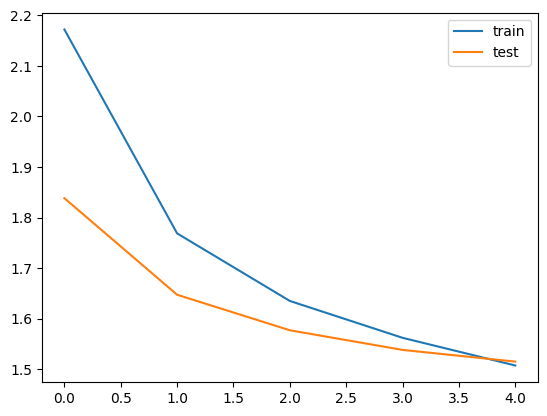

In [10]:
import matplotlib.pyplot as plt

# Retrieve data
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the data on the axis
ax.plot(train_loss, label='train')
ax.plot(test_loss, label='test')

# Add legend to the axis
ax.legend()

# Display the plot
plt.show()


In [11]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb_layer(decoder_inputs), initial_state=[decoder_state_input_h, decoder_state_input_c])

decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])

In [12]:
def seq2summary(input):
    summary = [
        y_tokenizer.index_word[i]
        for i in input
        if i != 0
        and i != y_tokenizer.word_index["sostok"]
        and i != y_tokenizer.word_index["eostok"]
    ]
    return " ".join(summary)

def seq2text(input):
    text = [
        x_tokenizer.index_word[i]
        for i in input
        if i != 0
    ]
    return " ".join(text)


In [13]:
for i in range(20, 30):
  print("Review:", seq2text(x_val[i]))
  print("summarized summary:", seq2summary(y_val[i]))
  print("\n")

Review: dalfour sugar added jams excellent never disappointed flavors rather adding sugar jams sweetened fruit juice dalfour jams found stores area flavor availability varies found pomegranate raspberry marshall several months ago quickly became favorite able find recently happy find amazon small jars handy
summarized summary: great no sugar added jam


Review: tastes heres idea taste like never could probably achieve similar taste common instant ramen cook without seasoning drain add half seasoning packet dash veg oil dab sweet soy sauce sweet soy sauce main difference noodles importantly online price double would pay asian grocery furthermore street price indonesia cents pack whereas price per pack
summarized summary: mi goreng


Review: anyone lived germany knows asbach uralt brand make best cordial cherries world purchased box mom comment delicious quickly former resident germany highly recommend delicious brandy filled cordial cherries anyone need cool gift idea asbach uralt produ

# Traditional Modeling  VS  Pre-Trained Models

### **Review Summarization using BERT**

In [ ]:
!pip install bert-extractive-summarizer
!pip install sacremoses
!pip install -U sentence-transformers
!pip install spacy
!pip install transformers # > 4.0.0
!pip install neuralcoref

!python -m spacy download en_core_web_md
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 22.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=a17e4dfd200e47ef2f7ee6d08f29cfb47dd3cbf6ad3a20045fa06a964c4c921d
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

# Load the pre-trained BERT model and corresponding tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

# Prepare training data by converting the text into the format that tokenizer accepts
train_sentences = []
train_input_ids = []
train_attention_masks = []
for sent in train_sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True, 
                        max_length = 64,       
                        pad_to_max_length = True,       # Shorter sentences will be padded
                        return_attention_mask = True,   # Attention mask to mask out padding
                        return_tensors = 'tf',          # Return tf.tensor objects
                   )
    train_input_ids.append(encoded_dict['input_ids'])
    train_attention_masks.append(encoded_dict['attention_mask'])

# Convert input data into tf.Tensor objects
train_input_ids = tf.concat(train_input_ids, axis=0)
train_attention_masks = tf.concat(train_attention_masks, axis=0)

# Build the input layer of the BERT model
input_ids = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name='input_ids')
attention_masks = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name='attention_masks')
bert_inputs = {'input_ids': input_ids, 'attention_mask': attention_masks}

bert_output = bert_model(bert_inputs)[0]
output = tf.keras.layers.Dense(2, activation='softmax', name='output')(bert_output)

# Build the training model
model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
# Set optimizer, loss function, and evaluation metrics, etc.
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


'''model.fit(
    {'input_ids': train_input_ids, 'attention_masks': train_attention_masks},
    {'output': [0, 1]},   # Simulated label data
    epochs=3,
    batch_size=32
)'''


In [ ]:
from summarizer import Summarizer

body = '''I recently purchased a pair of wireless earbuds and I have to say, they are absolutely fantastic! The sound quality is amazing, 
 with crystal clear audio and deep, rich bass. I was blown away by how immersive my music sounded when I listened to it on these earbuds.
But that's not all - the design is sleek and modern, and the earbuds fit perfectly in my ears without ever feeling uncomfortable or falling out. 
And the charging case is compact and easy to use, making it convenient to keep my earbuds charged up and ready to go.
One of the things I appreciate most about these earbuds is the touch controls - I can easily pause, play, skip tracks, 
and adjust the volume without ever having to take my phone out of my pocket. It's so convenient when I'm on the go or trying to multitask.
Overall, I would highly recommend these wireless earbuds to anyone looking for a high-quality audio experience in a compact, user-friendly package. 
They have truly exceeded my expectations and I can't imagine going back to wired earbuds ever again.
'''

model = Summarizer()
result = model(body, min_length=60)
result = ''.join(result)


In [ ]:
print(result)

I recently purchased a pair of wireless earbuds and I have to say, they are absolutely fantastic! But that's not all - the design is sleek and modern, and the earbuds fit perfectly in my ears without ever feeling uncomfortable or falling out.


reference:  
https://www.kaggle.com/code/aravindanr22052001/sentimentanalysis  
https://sellesta.ai/blog/amazon-review-sentiment-analysis/  
https://www.kaggle.com/code/pchamoli191900/lstm-amazon-reviews  
https://www.kaggle.com/code/currie32/summarizing-text-with-amazon-reviews  
https://www.kaggle.com/code/singhabhiiitkgp/text-summarization-using-lstm  

